## Seminar 3 - FFT filter bank

4 subband FFT filter bank should be comared with FB from Seminar 3.

In [3]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.optimize as opt
import scipy.io.wavfile as wav
import pyaudio
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,6]

Load audio file

In [25]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
Data Type:  int16
Shape of one channel: (220500,)


In [39]:
nTabs = 64
blocksize = 8
nSubbands = 4

FFT via FFT Matrix

In [40]:
I = np.eye(blocksize)
fftMat = np.fft.fft(I)
print(fftMat.shape)

(8, 8)


Compute Blockwise fft on blocks of 8 samples:

In [37]:
newlength = audio.shape[0] - (audio.shape[0] % blocksize) # length so it fits into blocks of size blocksize
stackedBlocks = np.reshape(audio[0:newlength],(int(newlength/blocksize), blocksize))
transformed = np.dot(stackedBlocks,fftMat)

/home/jole/programs/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


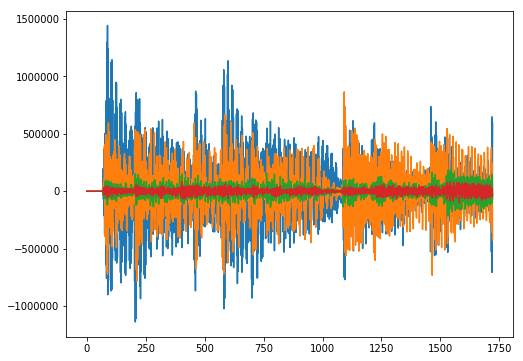

In [38]:
plt.plot(transformed[:,0])
plt.plot(transformed[:,1])
plt.plot(transformed[:,2])
plt.plot(transformed[:,3])
plt.show()